In [1]:
#!/usr/bin/env python3
#
# Copyright 2021 University of Edinburgh
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
#  * Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
#  * Redistributions in binary form must reproduce the above copyright
#    notice, this list of conditions and the following disclaimer in the
#    documentation and/or other materials provided with the distribution.
#  * Neither the name of  nor the names of its contributors may be used to
#    endorse or promote products derived from this software without specific
#    prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

%matplotlib notebook
import rospy
from visualization_msgs.msg import MarkerArray
from visualization_msgs.msg import Marker
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import pickle
import numpy as np
from walkgen.tools.geometry_utils import order, compute_inner_inequalities, compute_inner_vertices
import visvalingamwyatt as vw 
from time import perf_counter as clock
from enum import Enum
from scipy.spatial import ConvexHull
import walkgen.tools.Tess2 as Tess
from scipy.spatial import distance 
from shapely.geometry import Polygon 
import sl1m.tools.plot_tools as plot
from example_robot_data.robots_loader import ANYmalLoader

#load Marker array class example from ROS simulation
fileObject = "/home/thomas_cbrs/Desktop/edin/sl1m_integration_memmo/example_marker_array.pickle"

with open(fileObject, 'rb') as file2:
    array_markers = pickle.load(file2)

Import error: No module GLPK
Academic license - for non-commercial use only - expires 2022-09-29
Using license file /home/thomas_cbrs/gurobi.lic
Parameter LogFile unchanged
   Value:   Default: 


Plot surfaces given given by MarkerArray topic, no processing.

<IPython.core.display.Javascript object>


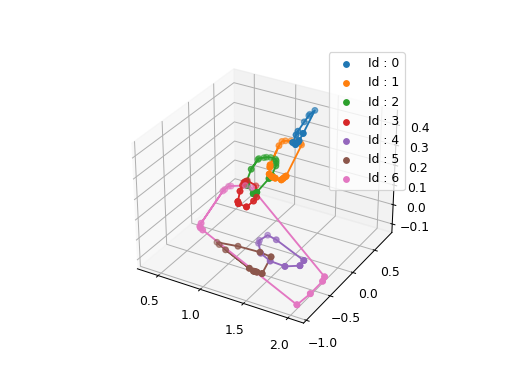

<Axes3DSubplot:>

In [4]:
from walkgen.tools.plot_tools import plot_marker_surface

plot_marker_surface(array_markers)

Compare different methods to reduce the number of points

<IPython.core.display.Javascript object>


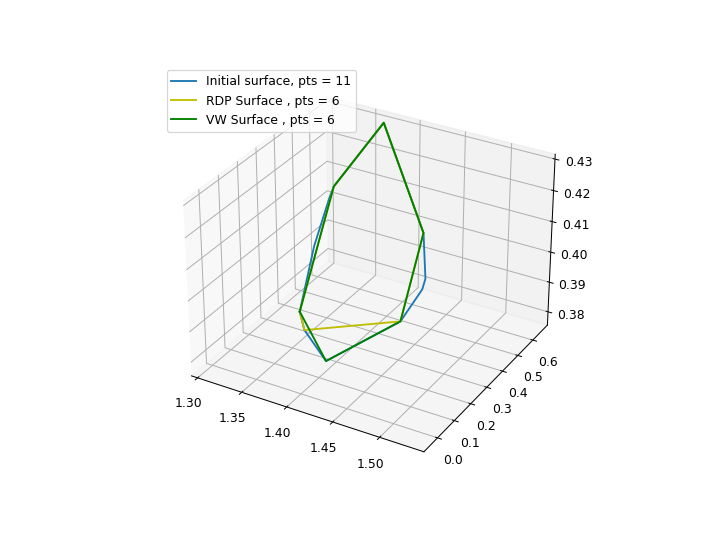

In [5]:
# Compare different methods to reduce the number of points
from rdp import rdp,rdp_iter, rdp_rec

# Initial list
points_ = array_markers.markers[0].points
pts = [[points_[2*k].x, points_[2*k].y,points_[2*k].z] for k in range(int((len(points_)-1 )/ 2))]
pts.append([points_[-1].x, points_[-1].y, points_[-1].z])

# RDP Algo
pts_rdp = rdp(pts, epsilon=0.05) # Cannot tune the final number of points
# VW Algo
simplifier = vw.Simplifier(pts)
pts_vw = simplifier.simplify(number=6).tolist()

# Vizualisation purpose
pts.append([points_[0].x, points_[0].y, points_[0].z]) 
pts_rdp.append(pts_rdp[0])
pts_vw.append(pts_vw[0])

# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

X = np.array(pts)[:,0]
Y = np.array(pts)[:,1]
Z = np.array(pts)[:,2]
X_r = np.array(pts_rdp)[:,0]
Y_r = np.array(pts_rdp)[:,1]
Z_r = np.array(pts_rdp)[:,2]
X_v = np.array(pts_vw)[:,0]
Y_v = np.array(pts_vw)[:,1]
Z_v = np.array(pts_vw)[:,2]

ax.plot3D(X,Y,Z, label='Initial surface, pts = ' + str(len(pts)-1))
ax.plot3D(X_r,Y_r,Z_r, label='RDP Surface , pts = ' + str(len(pts_rdp)-1),color ="y")
ax.plot3D(X_v,Y_v,Z_v, label='VW Surface , pts = ' + str(len(pts_vw)-1), color = "g")
ax.legend(loc="upper left")

Extract an inner surface with a margin.

<IPython.core.display.Javascript object>


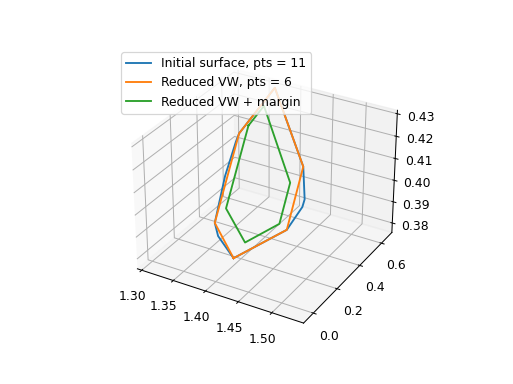

In [5]:
# Prepare surfaces, received from MarkerArray

# Sort the incoming list in list of vertex, example on first array
points_ = array_markers.markers[0].points

# Marker structure :
# [Pt1,Pt2,Pt2,Pt3,Pt3,Pt4, ... , Ptn-1, Ptn, Pt1, Ptn] !Warning order at the end

pts = [[pt.x,pt.y,pt.z] for pt in points_] # List not sorted, with duplicates
vertices = order(np.array(pts))

# Reduce the number of point using Visvalingam’s algorithm 
simplifier = vw.Simplifier(vertices)
vertices_vw = simplifier.simplify(number=6)

margin = 0.02
ineq_inner, ineq_inner_vect, normal = compute_inner_inequalities(vertices_vw, margin)
vertices_inner = compute_inner_vertices(vertices_vw, ineq_inner, ineq_inner_vect )
vertices_inner = order(vertices_inner) # If margin create intersection, need to be sorted

# Plot surfaces
fig = plt.figure()
ax = plt.axes(projection='3d')

vert_inner_list = vertices_inner.tolist()
vert_inner_list.append(vert_inner_list[0])
vert_list = vertices.tolist()
vert_list.append(vertices[0])
vert_vw_list = vertices_vw.tolist()
vert_vw_list.append(vert_vw_list[0])
X = np.array(vert_list)[:,0]
Y = np.array(vert_list)[:,1]
Z = np.array(vert_list)[:,2]
X_r = np.array(vert_inner_list)[:,0]
Y_r = np.array(vert_inner_list)[:,1]
Z_r = np.array(vert_inner_list)[:,2]
X_v = np.array(vert_vw_list)[:,0]
Y_v = np.array(vert_vw_list)[:,1]
Z_v = np.array(vert_vw_list)[:,2]

ax.plot3D(X,Y,Z, label='Initial surface, pts = ' + str(len(vertices)))
ax.plot3D(X_v,Y_v,Z_v, label='Reduced VW, pts = ' + str(len(vertices_vw)))
ax.plot3D(X_r,Y_r,Z_r, label='Reduced VW + margin')
ax.legend(loc="upper left")

Exemple of Tess algorithm :
from https://github.com/azrafe7/hxGeomAlgo

Run took [ms]:  4.014623998955358


<IPython.core.display.Javascript object>


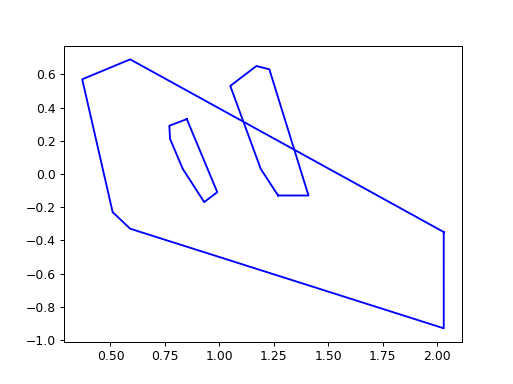

<IPython.core.display.Javascript object>


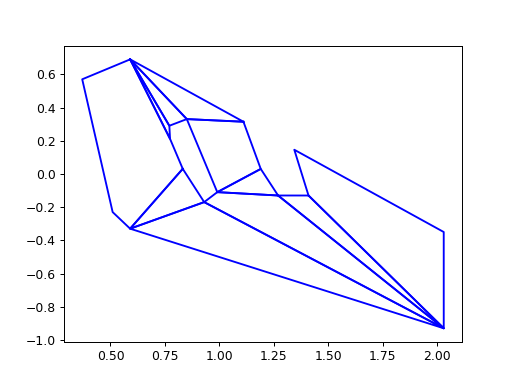

In [12]:
from walkgen.tools.geometry_utils import reduce_surfaces, process_tess_results, get_contour
from walkgen.tools.plot_tools import plot_contour, plot_surface2D

all_surfaces = reduce_surfaces(array_markers, margin = 0.0, n_points=6)

#Projection on Z axis
ca = get_contour(all_surfaces[6])
cb = get_contour(all_surfaces[1])
cc = get_contour(all_surfaces[3])

polySize = 10
tess = Tess.hxGeomAlgo_Tess2()
t0 = clock()
res = tess.difference([ca],[cb,cc], polySize=polySize)
surfaces = process_tess_results(res, polySize)
t1 = clock()
print("Run took [ms]: ", 1000. * (t1-t0))

#Plot contours
ax = plot_contour(ca)
plot_contour(cb, ax)
plot_contour(cc, ax)

# Plot results
fig = plt.figure()
ax = plt.axes()
for i,sf in enumerate(surfaces) :
    plot_surface2D(sf, ax=ax)


Result of the data processing, following this method :

Reduce the incoming surfaces.
1. The vertices received are sorted counterclockwise, duplicates removed.
2. The number of vertices is reduced using Visvalingam-Wyatt algorithm.
3. An interior surface is calculated, with a margin parallel to each edge.

Decomposition and filtering of the surfaces obtain. Projection of the surfaces in X,Y plan and reshape them to avoid overlaying using Tesselation algorithm:
1. Run the list of surfaces starting with the lowest.
2. Decomposes the lowest surface in set of convex ones by removing the upper surfaces that overlap it.
   (Tesselation algorithm).
   Use one of the 4 methods listed in DECOMPO_type to select/intersect the surfaces. 
3. Delate surface from the list and continue.

<IPython.core.display.Javascript object>


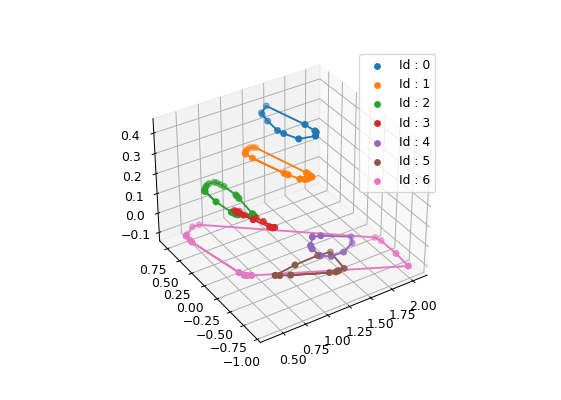

<IPython.core.display.Javascript object>


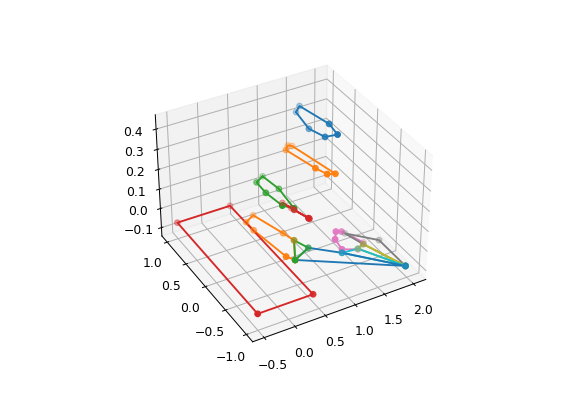

In [15]:
from walkgen.tools.geometry_utils import remove_overlap_surfaces
# PLot initial surfaces
fig = plt.figure(figsize=(7, 5))
ax = plt.axes(projection="3d")
plot_marker_surface(array_markers, ax)

# Add initial surface
h_init = -0.06
init_vertices = np.array([[0.4, -1, h_init],[0.4,1.,h_init],[-0.5,1.,h_init],[-0.5,-1,h_init]])



# PARAMETERS FOR SURFACES PROCESSING 
margin = 0.
n_points = 6
method_id = 3
polySize = 10
min_area = 0.03

# Reduce and sort incoming data
all_surfaces = reduce_surfaces(array_markers, margin=margin, n_points=n_points)

# Apply proccess to filter and decompose the surfaces
g = remove_overlap_surfaces(all_surfaces, polySize=polySize, method=method_id, min_area=min_area, initial_floor=init_vertices.T)


# Plot process result
plt.figure(figsize=(7, 5))
ax = plt.axes(projection='3d')
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
         '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i,sf in enumerate(g):
    plot.plot_surface(sf,ax=ax, color_id=i )
    ax.scatter(sf[0,:],sf[1,:],sf[2,:], color=COLORS[i % len(COLORS)])

Run MIP [ms] 8480.085769999278


<IPython.core.display.Javascript object>


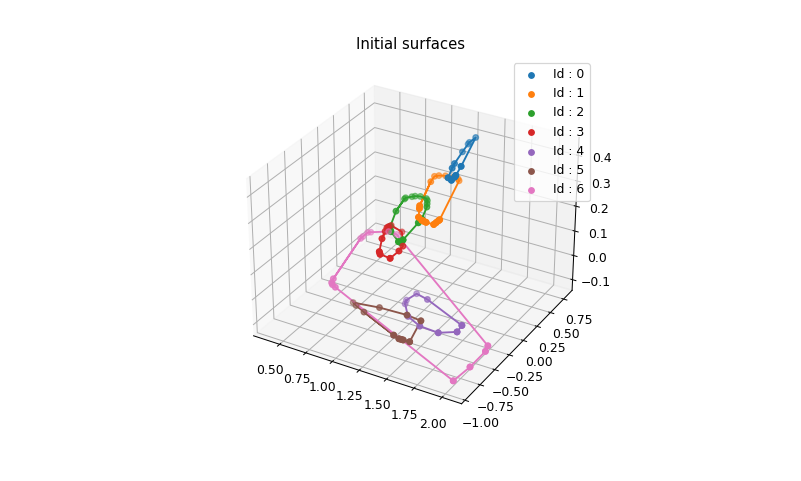

<IPython.core.display.Javascript object>


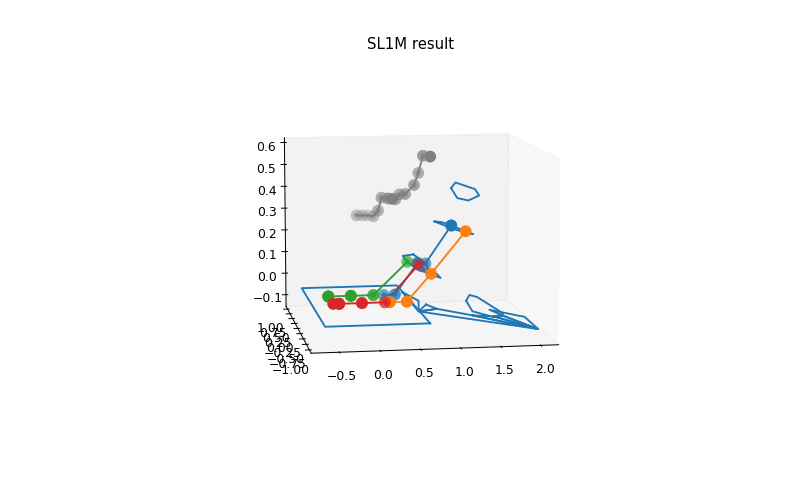

In [18]:
import walkgen.SurfacePlanner as SurfacePlanner
import pinocchio as pin
# PARAMETERS FOR SURFACES PROCESSING
margin = 0.
n_points = 6
method_id = 3
polySize = 10
min_area = 0.03

# SL1M PARAMETERS
N_phase = 15

# WALKING PARAMETERS
T_gait = 2.
n_gait = 4  # Number of different phases in the gait

gait = np.array([[0.,1.,1.,1.],
                 [1.,0.,1.,1.],
                 [1.,1.,0.,1.],
                 [1.,1.,1.,0.]])
# gait = np.array([[0.,1.,0.,1.],
#                  [1.,0.,1.,0.]])
bvref = np.array([0.15,0.,0.]) # Reference velocity
initial_config = np.array([0.,0.3,0.,0.,0.,0.,1.]) # Initial config
h_init = -0.06
init_vertices = np.array([[0.65, -1, h_init], [0.65, 1., h_init], [-0.65, 1., h_init], [-0.65, -1, h_init]])

surface_planner = SurfacePlanner(N_phase,
                                 n_gait,
                                 T_gait,
                                 margin=margin,
                                 n_points=n_points,
                                 method_id=method_id,
                                 polySize=polySize,
                                 min_area=min_area,
                                 init_vertices=init_vertices )

# Initialisation of model quantities, get feet current position
anymal = surface_planner.anymal
q = anymal.q0.copy()
q[:3] = initial_config[:3]
pin.centerOfMass(anymal.model, anymal.data, q)
pin.updateFramePlacements(anymal.model, anymal.data)
pin.crba(anymal.model, anymal.data, q)

indexes = ['LF_FOOT', 'RF_FOOT', 'LH_FOOT', 'RH_FOOT']
current_contacts = np.zeros((3,4))
for i,idx in enumerate(indexes) :
    Id = anymal.model.getFrameId(idx)
    current_contacts[:,i] = anymal.data.oMf[Id].translation
current_contacts[2,:] = h_init

# List of configurations in planned horizon, using the reference velocity.
configs = []
configs.append(initial_config.tolist())
for i in range(1,N_phase):
    config = np.zeros(7)
    config[:3] = bvref*(T_gait/n_gait)*i + initial_config[:3]
    rpy = np.array([0.,0.,0.])
    config[3:] = pin.Quaternion(pin.rpy.rpyToMatrix(rpy)).coeffs()
    configs.append(config.tolist())

t0 = clock()
vertices, inequalities, indices = surface_planner.run(array_markers, configs, gait, current_contacts, bvref)
t1 = clock()

print("Run MIP [ms]", 1000. * (t1 - t0))

# Plot initial surfaces from markerArray
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
plt.title("Initial surfaces")
plot_marker_surface(array_markers,ax)

# Plot SL1M results
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
plt.title("SL1M result")
for sf in surface_planner.surfaces_processed :
    plot.plot_surface(sf,ax=ax)
plot.plot_planner_result(surface_planner.pb_data.all_feet_pos, coms=surface_planner.pb_data.coms, ax=ax, show=True)